# Optimism Batcher - L1 transaction analysis

#### Maria Silva, February 2024

In [1]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## Data preparation 

In [2]:
raw_df = pd.read_csv("../data/op-batcher-txs-6-months.csv")
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133760 entries, 0 to 133759
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   hash                   133760 non-null  object 
 1   block_timestamp        133760 non-null  object 
 2   gas_used               133760 non-null  int64  
 3   gas_used_final         133760 non-null  int64  
 4   gas_price_gwei         133760 non-null  float64
 5   gas_price_final_gwei   133760 non-null  float64
 6   max_priority_fee_gwei  133760 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 7.1+ MB


In [3]:
batcher_df = raw_df.copy()
batcher_df["timestamp"] = pd.to_datetime(raw_df['block_timestamp'])
batcher_df['gas_estimation_err'] = batcher_df['gas_used']-batcher_df['gas_used_final']
batcher_df['gas_limit_million'] = batcher_df['gas_used']/1000000
batcher_df['gas_used_million'] = batcher_df['gas_used_final']/1000000
batcher_df["post_freq_sec"]= batcher_df["timestamp"].diff().dt.seconds

cols = ["timestamp", "gas_limit_million", "gas_used_million","gas_estimation_err", 
        "post_freq_sec", "gas_price_final_gwei", "max_priority_fee_gwei"]
batcher_df = batcher_df[cols]
batcher_df.head()

,timestamp,gas_limit_million,gas_used_million,gas_estimation_err,post_freq_sec,gas_price_final_gwei,max_priority_fee_gwei
0,2023-08-16 00:00:47+00:00,1.935300,1.935300,0,NaN,23.358366,0.030290
1,2023-08-16 00:01:47+00:00,1.935348,1.935348,0,60.0,24.829041,0.042892
2,2023-08-16 00:02:47+00:00,1.935168,1.935168,0,60.0,26.331950,0.043769
3,2023-08-16 00:03:59+00:00,1.935144,1.935144,0,72.0,24.863292,0.043769
4,2023-08-16 00:05:47+00:00,1.935312,1.935312,0,108.0,23.207266,0.043769


## Gas usage

In [4]:
temp_df = (
    batcher_df
    [["gas_limit_million", "gas_used_million", "gas_estimation_err"]]
    .agg(["mean", "std", "skew"])
    .round(2)
).T
temp_df["coef_var"] = (temp_df["std"]/temp_df["mean"]).round(2)
temp_df

,mean,std,skew,coef_var
gas_limit_million,1.86,0.08,-10.50,0.04
gas_used_million,1.86,0.08,-10.52,0.04
gas_estimation_err,84.86,1166.30,13.68,13.74


In [5]:
(batcher_df
 [["gas_limit_million", "gas_used_million", "gas_estimation_err"]]
 .quantile([0, 0.25, 0.5, 0.75, 1])
 .round(2)
).T

,0.00,0.25,0.50,0.75,1.00
gas_limit_million,0.02,1.86,1.87,1.89,1.95
gas_used_million,0.02,1.86,1.87,1.89,1.94
gas_estimation_err,0.00,0.00,0.00,0.00,16514.00


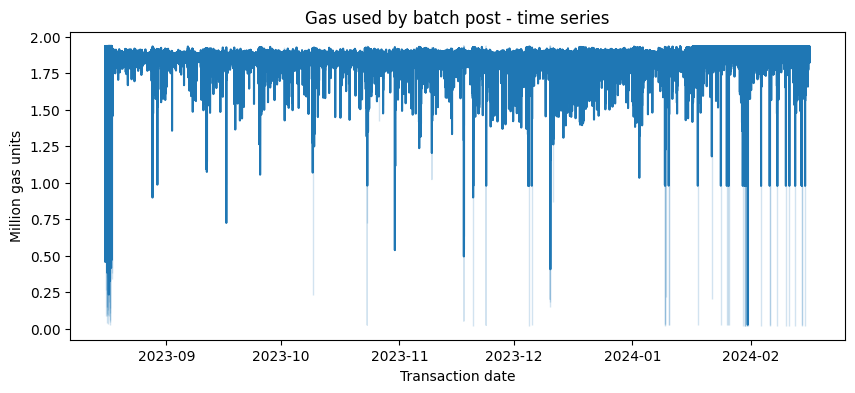

In [6]:
plt.figure(figsize=(10,4))
sns.lineplot(data=batcher_df, x='timestamp', y='gas_used_million')
plt.title("Gas used by batch post - time series")
plt.xlabel('Transaction date')
plt.ylabel('Million gas units')
plt.show()

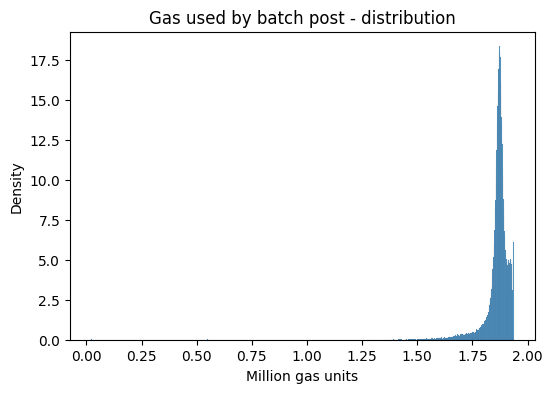

In [7]:
plt.figure(figsize=(6,4))
sns.histplot(data=batcher_df, x='gas_used_million', stat='density')
plt.title("Gas used by batch post - distribution")
plt.xlabel('Million gas units')
plt.ylabel('Density')
plt.show()

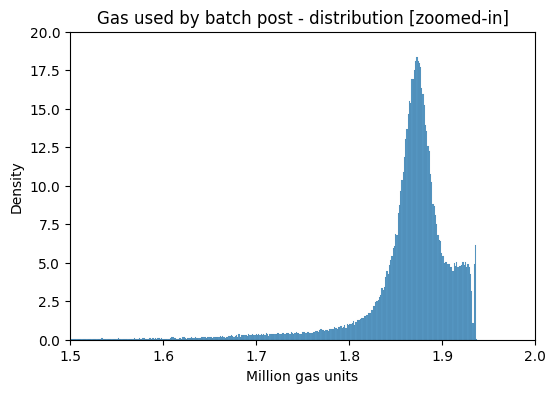

In [8]:
plt.figure(figsize=(6,4))
sns.histplot(data=batcher_df, x='gas_used_million', stat='density')
plt.title("Gas used by batch post - distribution [zoomed-in]")
plt.xlabel('Million gas units')
plt.ylabel('Density')
plt.xlim(1.5, 2)
plt.ylim(0,20)
plt.show()

## Posting frequency

In [9]:
temp_df = (
    batcher_df
    [["post_freq_sec"]]
    .agg(["mean", "std", "skew"])
    .round(2)
).T
temp_df["coef_var"] = (temp_df["std"]/temp_df["mean"]).round(2)
temp_df

,mean,std,skew,coef_var
post_freq_sec,119.14,56.04,0.71,0.47


In [10]:
(batcher_df
 [["post_freq_sec"]]
 .quantile([0, 0.25, 0.5, 0.75, 1])
 .round(2)
).T

,0.00,0.25,0.50,0.75,1.00
post_freq_sec,0.0,72.0,120.0,156.0,1596.0


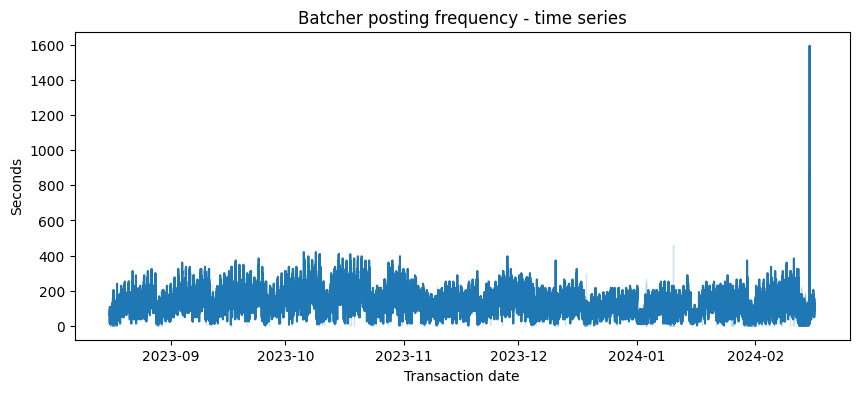

In [11]:
plt.figure(figsize=(10,4))
sns.lineplot(data=batcher_df, x='timestamp', y='post_freq_sec')
plt.title("Batcher posting frequency - time series")
plt.xlabel('Transaction date')
plt.ylabel('Seconds')
plt.show()

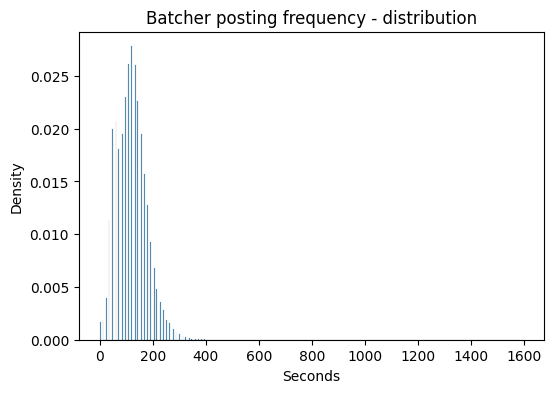

In [12]:
plt.figure(figsize=(6,4))
sns.histplot(data=batcher_df, x='post_freq_sec', stat='density')
plt.title("Batcher posting frequency - distribution")
plt.xlabel('Seconds')
plt.ylabel('Density')
plt.show()

## L1 gas prices - priority fees

In [13]:
temp_df = (
    batcher_df
    [["max_priority_fee_gwei"]]
    .agg(["mean", "std", "skew"])
    .round(2)
).T
temp_df["coef_var"] = (temp_df["std"]/temp_df["mean"]).round(2)
temp_df

,mean,std,skew,coef_var
max_priority_fee_gwei,0.03,0.64,205.56,21.33


In [14]:
(batcher_df
 [["max_priority_fee_gwei"]]
 .quantile([0, 0.25, 0.5, 0.75, 1])
 .round(2)
).T

,0.00,0.25,0.50,0.75,1.00
max_priority_fee_gwei,0.0,0.01,0.01,0.03,148.68


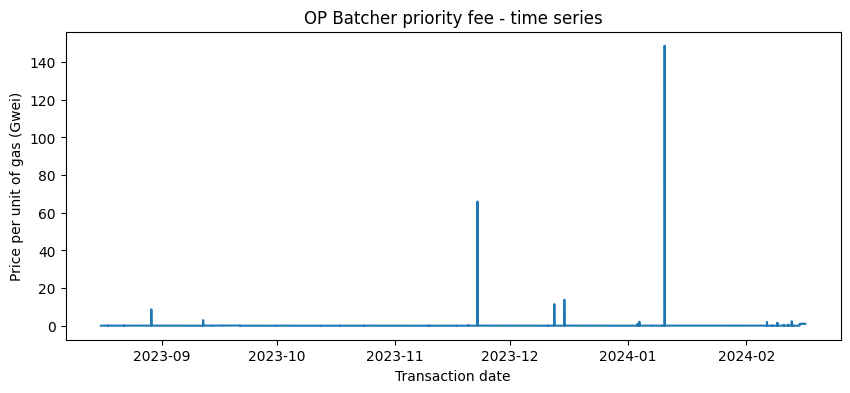

In [15]:
plt.figure(figsize=(10,4))
sns.lineplot(data=batcher_df, x='timestamp', y='max_priority_fee_gwei')
plt.title("OP Batcher priority fee - time series")
plt.xlabel('Transaction date')
plt.ylabel('Price per unit of gas (Gwei)')
plt.show()

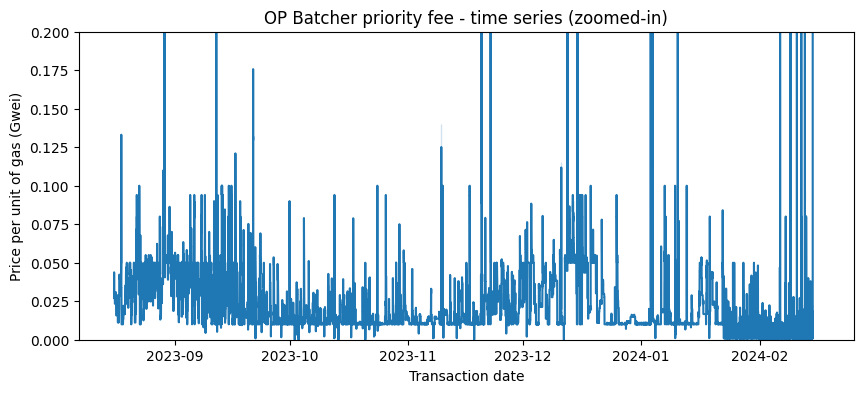

In [16]:
plt.figure(figsize=(10,4))
sns.lineplot(data=batcher_df, x='timestamp', y='max_priority_fee_gwei')
plt.title("OP Batcher priority fee - time series (zoomed-in)")
plt.xlabel('Transaction date')
plt.ylabel('Price per unit of gas (Gwei)')
plt.ylim(0,0.2)
plt.show()

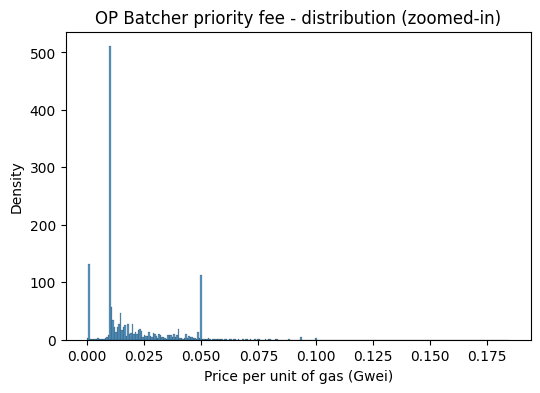

In [17]:
temp = batcher_df[batcher_df["max_priority_fee_gwei"]<0.2]
plt.figure(figsize=(6,4))
sns.histplot(data=temp, x='max_priority_fee_gwei', stat='density')
plt.title("OP Batcher priority fee - distribution (zoomed-in)")
plt.xlabel('Price per unit of gas (Gwei)')
plt.ylabel('Density')
plt.show()

## L1 gas prices - total fees

In [18]:
temp_df = (
    batcher_df
    [["gas_price_final_gwei"]]
    .agg(["mean", "std", "skew"])
    .round(2)
).T
temp_df["coef_var"] = (temp_df["std"]/temp_df["mean"]).round(2)
temp_df

,mean,std,skew,coef_var
gas_price_final_gwei,26.43,19.6,4.38,0.74


In [19]:
(batcher_df
 [["gas_price_final_gwei"]]
 .quantile([0, 0.25, 0.5, 0.75, 1])
 .round(2)
).T

,0.00,0.25,0.50,0.75,1.00
gas_price_final_gwei,4.65,13.67,21.89,33.57,608.87


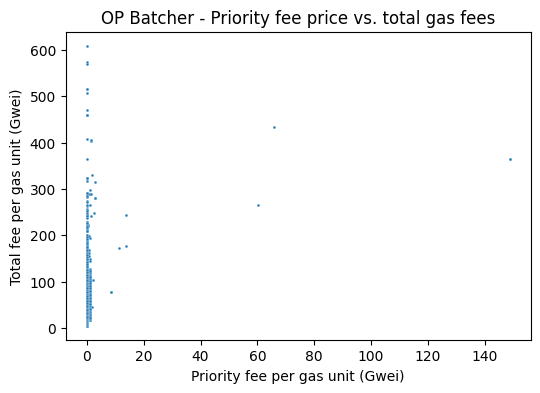

In [20]:
plt.figure(figsize=(6,4))
sns.scatterplot(data=batcher_df, x='max_priority_fee_gwei', y='gas_price_final_gwei', s=4)
plt.title("OP Batcher - Priority fee price vs. total gas fees")
plt.xlabel('Priority fee per gas unit (Gwei)')
plt.ylabel('Total fee per gas unit (Gwei)')
plt.show()

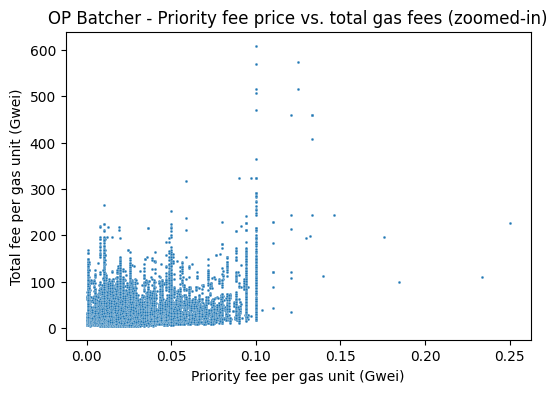

In [21]:
temp = batcher_df[batcher_df["max_priority_fee_gwei"]<0.3]
plt.figure(figsize=(6,4))
sns.scatterplot(data=temp, x='max_priority_fee_gwei', y='gas_price_final_gwei', s=4)
plt.title("OP Batcher - Priority fee price vs. total gas fees (zoomed-in)")
plt.xlabel('Priority fee per gas unit (Gwei)')
plt.ylabel('Total fee per gas unit (Gwei)')
plt.show()